In [1]:
import numpy as np
import pandas as pd

In [2]:
import torch
from torch.utils.data import Dataset, DataLoader

In [3]:
import models

In [4]:
import os
os.makedirs("./saved_models/", exist_ok=True)

In [5]:
train_VAE = False
train_GAN = False
train_NF  = True

In [6]:
E = 200 # GeV
M = 114 # GeV
c = 1

In [7]:
# input_dimension = 50
# data = np.random.beta(1, 2, (100_000, input_dimension))

In [8]:
data = np.loadtxt("data/events.txt")

# Delete Energy (E) entries
# data = np.delete(data, [0, 4], axis=1)

# Delete theta and phi
data = np.delete(data, [8, 9], axis=1)
input_dimension = data.shape[1]

In [9]:
data.mean(), data.std()

(25.24994401635484, 66.4280034159734)

In [10]:
data.shape

(100000, 8)

In [11]:
latent_dim = 100
device = 'cuda' if torch.cuda.is_available() else 'cpu'
vae = models.VAE(input_dimension, latent_dim, device=device).to(device)
vae_optimizer = torch.optim.Adam(vae.parameters(), lr=1e-3) 


In [12]:
print(device, vae_optimizer.defaults)

cpu {'lr': 0.001, 'betas': (0.9, 0.999), 'eps': 1e-08, 'weight_decay': 0, 'amsgrad': False}


In [13]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)
count_parameters(vae)

1365208

In [14]:
class PCDataset(Dataset):
    def __init__(self, data, transform=None):
        self.data = data
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        item = self.data[idx]
        if self.transform:
            item = self.transform(item)
        return item

In [15]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
X_train, X_test = train_test_split(data, test_size=0.15, random_state=42)
scaler = StandardScaler().fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

In [16]:
print(X_train.mean(), X_train.std())
print(X_test.mean(), X_test.std())

4.988028616292231e-12 0.9999999999999999
2.5556058295948083e-05 1.0032579828462234


In [17]:
train_dataset = PCDataset(X_train)
val_dataset = PCDataset(X_test)

In [18]:
train_dataloader = DataLoader(train_dataset, batch_size=256, shuffle=True)
test_dataloader = DataLoader(val_dataset, batch_size=256, shuffle=True)

In [19]:
import time

In [20]:
def train_VAE_helper(epochs):
    vae.train()

    for i in range(epochs):

        start_time = time.time()

        vae_loss_avg, recon_loss_avg, KL_loss_avg = 0, 0, 0

        for batch in train_dataloader:

            vae_loss, recon_loss, KL_loss = vae.loss_function(batch.float().to(device))

            vae_loss_avg += vae_loss.detach().cpu().numpy() / len(train_dataloader)
            recon_loss_avg += recon_loss.detach().cpu().numpy() / len(train_dataloader)
            KL_loss_avg += KL_loss.detach().cpu().numpy() / len(train_dataloader)

            vae_optimizer.zero_grad()
            vae_loss.backward()
            vae_optimizer.step()

        print("Epoch:", i+1, f"time passed: {time.time() - start_time:.2f}s", f"Train Losses (avg.): vae={vae_loss_avg:.5f}, recon={recon_loss_avg:.5f}, kl={KL_loss_avg:.5f}")

In [21]:
if train_VAE:
    train_VAE_helper(25)
    torch.save(vae.state_dict(), "./saved_models/vae-25e")

In [22]:
input = torch.tensor(X_test).float().to(device)

In [23]:
input

tensor([[-0.4450,  1.7686, -0.5562,  ..., -1.7686,  0.5562, -0.4366],
        [ 1.0305,  0.5344, -1.8574,  ..., -0.5344,  1.8574, -1.4185],
        [ 0.9248,  1.8641,  0.5211,  ..., -1.8641, -0.5211, -1.3171],
        ...,
        [ 0.7533, -1.4933, -1.2526,  ...,  1.4933,  1.2526, -1.0162],
        [-1.6089, -0.9841,  1.6691,  ...,  0.9841, -1.6691, -1.1514],
        [-0.7212, -0.6345,  1.7932,  ...,  0.6345, -1.7932, -1.5185]])

In [24]:
vae.eval()
output, _, _ = vae(input.float())

In [25]:
output.detach().cpu().numpy()

array([[ 0.21269076,  0.08223894,  0.14728498, ...,  0.05521317,
        -0.10790406,  0.00497104],
       [ 0.11668621,  0.12082759,  0.07714057, ...,  0.00969481,
         0.12814642, -0.10051254],
       [ 0.04248868,  0.13140886, -0.0128967 , ...,  0.00144976,
         0.1534228 , -0.07480445],
       ...,
       [ 0.14989728,  0.16229898,  0.11044201, ...,  0.0263228 ,
        -0.03090179, -0.02240129],
       [-0.07893754,  0.124944  , -0.02139035, ...,  0.13877362,
         0.06342752, -0.10206393],
       [ 0.08738572,  0.12574399, -0.00065855, ...,  0.05876401,
         0.09256162, -0.00203089]], dtype=float32)

In [26]:
import torch.nn.functional as F
F.mse_loss(input, output)

tensor(1.0168, grad_fn=<MseLossBackward0>)

In [27]:
scaler.inverse_transform(output.detach())

array([[ 1.01010447e+02,  4.20765285e+00,  7.99141865e+00, ...,
         2.85331915e+00, -5.96637604e+00,  5.12131558e+01],
       [ 1.01005663e+02,  6.18996742e+00,  4.38445827e+00, ...,
         5.15021911e-01,  6.17179283e+00,  4.63594421e+01],
       [ 1.01001966e+02,  6.73353163e+00, -2.45430772e-01, ...,
         9.14706402e-02,  7.47155267e+00,  4.75423724e+01],
       ...,
       [ 1.01007318e+02,  8.32036999e+00,  6.09688235e+00, ...,
         1.36920862e+00, -2.00677149e+00,  4.99536472e+01],
       [ 1.00995914e+02,  6.40142941e+00, -6.82190586e-01, ...,
         7.14585395e+00,  2.84382234e+00,  4.62880566e+01],
       [ 1.01004203e+02,  6.44252491e+00,  3.83878308e-01, ...,
         3.03572720e+00,  4.34195415e+00,  5.08909691e+01]])

In [28]:
scaler.inverse_transform(input.detach())

array([[100.97767136,  90.83617262, -28.18133728, ..., -90.83617262,
         28.18133728,  30.89663198],
       [101.05120271,  27.43679191, -95.09550229, ..., -27.43679191,
         95.09550229, -14.28524883],
       [101.04593388,  95.7434981 ,  27.2143253 , ..., -95.7434981 ,
        -27.2143253 ,  -9.62098303],
       ...,
       [101.03738629, -76.72693233, -63.99310538, ...,  76.72693233,
         63.99310538,   4.22612515],
       [100.91967194, -50.57134785,  86.24701884, ...,  50.57134785,
        -86.24701884,  -1.997712  ],
       [100.96390777, -32.61309232,  92.62601312, ...,  32.61309232,
        -92.62601312, -18.88935201]])

In [29]:
gan = models.GAN(input_shape = input_dimension)

In [30]:
count_parameters(gan), count_parameters(gan.discriminator), count_parameters(gan.generator)

(850825, 136193, 714632)

In [31]:
def train_GAN_helper(epochs):
    for i in range(epochs):

        start_time = time.time()

        d_loss_avg, g_loss_avg = 0, 0

        for batch in train_dataloader:

            d_loss, g_loss = gan.train_with_batch(batch.float().to(device))

            d_loss_avg += d_loss / len(train_dataloader)
            g_loss_avg += g_loss / len(train_dataloader)

        print("Epoch:", i+1, f"time passed: {time.time() - start_time:.2f}s", f"Train Losses (avg.): discriminator={d_loss_avg:.5f}, generator={g_loss_avg:.5f}")

In [32]:
if train_GAN:
    train_GAN_helper(25)
    torch.save(gan.state_dict(), "./saved_models/gan-25e")

In [33]:
gan.eval()
gan_generated = scaler.inverse_transform(gan.generate(15_000).detach())

In [34]:
pd.DataFrame(gan_generated).describe()

,0,1,2,3,4,5,6,7
count,15000.000000,15000.000000,15000.000000,15000.000000,15000.000000,15000.000000,15000.000000,15000.000000
mean,100.998727,-0.107366,-0.140147,-49.788179,100.998712,-0.485030,0.450150,49.543943
std,0.000273,0.212975,0.255184,0.246470,0.000241,0.275490,0.268723,0.219989
min,100.997647,-0.950946,-1.168702,-50.692859,100.997571,-1.626733,-0.481262,48.737677
25%,100.998543,-0.249658,-0.311239,-49.955858,100.998551,-0.668507,0.266135,49.395723
50%,100.998725,-0.108580,-0.135568,-49.797740,100.998709,-0.483737,0.442964,49.542580
75%,100.998907,0.034465,0.034847,-49.627236,100.998873,-0.301729,0.624775,49.691434
max,100.999871,0.857718,0.836318,-48.741844,100.999696,0.668173,1.575689,50.405486


In [35]:
dummy_data = torch.Tensor(torch.normal(0, 1, size=(15_000, latent_dim)))
vae.eval()
vae_generated = scaler.inverse_transform(vae.decode(dummy_data).detach())

In [36]:
pd.DataFrame(vae_generated).describe()

,0,1,2,3,4,5,6,7
count,15000.000000,15000.000000,15000.000000,15000.000000,15000.000000,15000.000000,15000.000000,15000.000000
mean,101.003633,6.607352,2.455530,-53.229759,100.997643,4.691672,0.749301,48.487728
std,0.003406,3.382686,3.640303,3.283413,0.003415,3.840356,3.409878,3.186219
min,100.990628,-5.387424,-12.776412,-69.031234,100.984131,-8.781057,-13.684114,35.544443
25%,101.001321,4.299061,0.003240,-55.398425,100.995375,2.110942,-1.571777,46.368505
50%,101.003630,6.602142,2.446447,-53.214163,100.997658,4.707313,0.703142,48.531014
75%,101.005898,8.882502,4.899012,-51.018013,100.999920,7.280812,3.071592,50.626983
max,101.019175,21.041895,19.817584,-39.860156,101.011252,19.198226,16.858255,62.116798


In [37]:
pd.DataFrame(scaler.inverse_transform(X_test)).describe()

,0,1,2,3,4,5,6,7
count,15000.000000,15000.000000,15000.000000,15000.000000,15000.000000,15000.000000,15000.000000,15000.000000
mean,100.999625,-0.251671,-0.124810,-50.612889,100.999935,0.251671,0.124810,50.612889
std,0.049860,51.369773,51.607820,46.222633,0.050101,51.369773,51.607820,46.222633
min,100.805305,-99.954406,-99.988495,-100.000000,100.806001,-99.980538,-99.999600,-70.612768
25%,100.965652,-37.010077,-36.297777,-93.403606,100.966527,-35.451142,-35.394070,11.379495
50%,100.999480,0.017226,-0.051379,-65.606204,100.999942,-0.017226,0.051379,65.606204
75%,101.033186,35.451142,35.394070,-11.379495,101.033859,37.010077,36.297777,93.403606
max,101.184850,99.980538,99.999600,70.612768,101.188842,99.954406,99.988495,100.000000


In [38]:
pd.DataFrame(scaler.inverse_transform(np.random.normal(0, 1, size=(15_000, 8)))).describe()

,0,1,2,3,4,5,6,7
count,15000.000000,15000.000000,15000.000000,15000.000000,15000.000000,15000.000000,15000.000000,15000.000000
mean,100.999583,0.112968,1.005752,-50.485199,100.999720,-0.128435,0.272536,51.152672
std,0.049495,51.483516,51.147356,46.223136,0.049224,51.471725,52.137097,45.579880
min,100.812811,-198.383644,-180.029885,-260.899299,100.815045,-201.867831,-176.171656,-128.984390
25%,100.965827,-34.962186,-33.926536,-81.401442,100.966387,-35.188081,-34.912937,20.776724
50%,100.999641,0.541853,0.961021,-50.265859,100.999479,0.075371,-0.272177,50.918808
75%,101.033475,35.192585,35.710950,-19.401305,101.032917,34.583711,35.592230,81.978589
max,101.202181,211.188691,185.856202,123.433865,101.186416,184.636505,257.558396,206.179208


In [42]:
# https://gebob19.github.io/normalizing-flows/
d = 8
k = 4
NF_model = models.stacked_NVP(d, k, hidden=512, n=3)
NF_optim = torch.optim.Adam(NF_model.parameters(), lr=1e-3)
nf_scheduler = torch.optim.lr_scheduler.ExponentialLR(NF_optim, 0.999)
n_samples = 512

In [49]:
single_NF_model = models.R_NVP(d, k, hidden=512)

In [43]:
def train_NF(model, epochs, optim, scheduler):
    losses = []
    for i in range(epochs):
        start_time = time.time()
        loss_avg = 0
        # get batch 
        for batch in train_dataloader:
            optim.zero_grad()
            z, log_pz, log_jacob = model(batch.float().to(device))
            loss = (-log_pz - log_jacob).mean()
            losses.append(loss)
            loss_avg += (loss / len(train_dataloader))
            loss.backward()
            optim.step()
            scheduler.step()
        print("Epoch:", i+1, f"time passed: {time.time() - start_time:.2f}s", f"Train Losses (avg.): {loss_avg:.5f}")
    return losses

In [44]:
if train_NF:
    losses = train_NF(NF_model, 25, NF_optim, nf_scheduler)

Epoch: 1 time passed: 5.54s Train Losses (avg.): -0.92002
Epoch: 2 time passed: 5.69s Train Losses (avg.): -4.18843
Epoch: 3 time passed: 5.38s Train Losses (avg.): -5.75667
Epoch: 4 time passed: 5.33s Train Losses (avg.): -6.69806
Epoch: 5 time passed: 5.91s Train Losses (avg.): -7.39400
Epoch: 6 time passed: 5.55s Train Losses (avg.): -7.77006
Epoch: 7 time passed: 5.28s Train Losses (avg.): -8.10853
Epoch: 8 time passed: 4.81s Train Losses (avg.): -8.35819
Epoch: 9 time passed: 5.82s Train Losses (avg.): -8.50338
Epoch: 10 time passed: 5.02s Train Losses (avg.): -8.63756
Epoch: 11 time passed: 5.95s Train Losses (avg.): -8.74871
Epoch: 12 time passed: 6.00s Train Losses (avg.): -8.80212
Epoch: 13 time passed: 6.19s Train Losses (avg.): -8.85033
Epoch: 14 time passed: 6.26s Train Losses (avg.): -8.89175
Epoch: 15 time passed: 6.19s Train Losses (avg.): -8.92553
Epoch: 16 time passed: 6.67s Train Losses (avg.): -8.94992
Epoch: 17 time passed: 7.20s Train Losses (avg.): -8.96277
Epoch:

In [65]:
import matplotlib.pyplot as plt
def view(model, losses):
    plt.plot(losses)
    plt.title("Model Loss vs Epoch")
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.show()

    Z = single_NF_model.base_dist.rsample(sample_shape=(15000,))
    X_hat = model.inverse(Z).detach().numpy()
    plt.scatter(X_hat[:, 0], X_hat[:, 1])
    plt.title("Inverse of Normal Samples Z: X = F^-1(Z)")
    plt.show()

    plt.scatter(X_test[:, 0], X_test[:, 1])
    plt.title("Test Data")
    plt.show()

    return X_hat

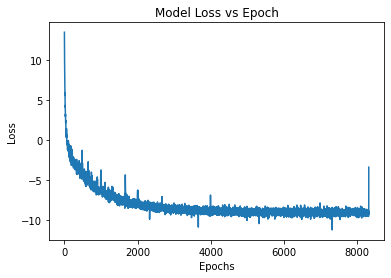

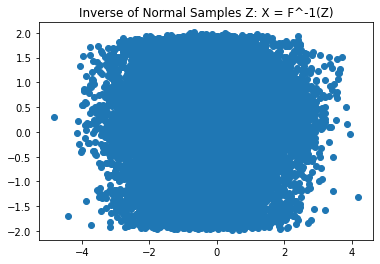

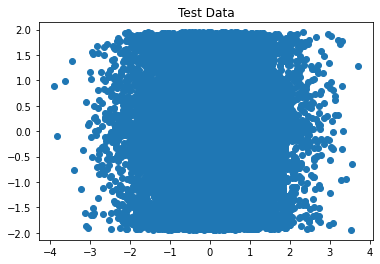

In [66]:
NF_generated = view(NF_model, list(map(lambda x : x.detach().numpy(), losses)))

In [67]:
pd.DataFrame(scaler.inverse_transform(NF_generated)).describe()

,0,1,2,3,4,5,6,7
count,15000.000000,15000.000000,15000.000000,15000.000000,15000.000000,15000.000000,15000.000000,15000.000000
mean,100.983727,2.754779,-0.259204,-43.710365,101.008118,-2.730639,0.455620,43.257168
std,0.068463,49.849991,44.267429,51.845772,0.274442,50.508751,44.574776,53.319489
min,100.758675,-101.663467,-104.873833,-101.169136,100.764320,-103.166435,-111.219002,-90.959244
25%,100.933588,-32.069183,-30.156458,-88.552847,100.916700,-40.386290,-29.971049,2.053146
50%,100.980354,4.013311,0.380720,-62.566345,100.958904,-4.247788,0.126491,63.619471
75%,101.031652,39.562526,29.921264,-3.573099,101.027411,32.982914,30.672843,89.279781
max,101.208893,103.383698,113.597099,79.766327,113.269226,102.562813,102.914604,101.045692


In [68]:
pd.DataFrame(scaler.inverse_transform(X_test)).describe()

,0,1,2,3,4,5,6,7
count,15000.000000,15000.000000,15000.000000,15000.000000,15000.000000,15000.000000,15000.000000,15000.000000
mean,100.999625,-0.251671,-0.124810,-50.612889,100.999935,0.251671,0.124810,50.612889
std,0.049860,51.369773,51.607820,46.222633,0.050101,51.369773,51.607820,46.222633
min,100.805305,-99.954406,-99.988495,-100.000000,100.806001,-99.980538,-99.999600,-70.612768
25%,100.965652,-37.010077,-36.297777,-93.403606,100.966527,-35.451142,-35.394070,11.379495
50%,100.999480,0.017226,-0.051379,-65.606204,100.999942,-0.017226,0.051379,65.606204
75%,101.033186,35.451142,35.394070,-11.379495,101.033859,37.010077,36.297777,93.403606
max,101.184850,99.980538,99.999600,70.612768,101.188842,99.954406,99.988495,100.000000


In [69]:
from sklearn.metrics import mean_squared_error

In [70]:
def rmse(generated):
    return mean_squared_error(scaler.inverse_transform(generated), scaler.inverse_transform(X_test))

In [71]:
print(rmse(NF_generated))
print(rmse(vae_generated))
print(rmse(gan_generated))

3679.8380062760016
1420730.6692090658
1308250.736564918
